In [67]:
import torch
import torch.nn as nn
import torch.autograd
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torch.utils.data as data

In [2]:
torch.cuda.manual_seed_all(225)
np.random.seed(225)

In [3]:
#### cvt2tensor = transforms.ToTensor()
cvt2pil = transforms.ToPILImage()

class Spacenet_Dataset(data.Dataset):
    def __init__(self, annotationsFile,train = True, transform=None):
        files = open(annotationsFile,'r')
        self.transform=transform
        items=[]
        #print(lines[0].split('\n'))
        for line in files:
            #print(line)
            imp,_ = line.split('\n')
            ip,out = imp.split(' ')
            ip = ip
            out = out[:-4]+'segcls.png'
            item = [ip,out]
            items.append(item)
        self.data = items
        self.inp_img_paths=[]
        self.out_img_paths=[]
        self.in_images = []
        self.out_images = []
        for dat in self.data:
            self.inp_img_paths.append(dat[0])
            self.out_img_paths.append(dat[1])

        
        for i in range(len(self.out_img_paths)):
            with Image.open(self.out_img_paths[i]) as handle:
                img = handle.convert('L')
                image_ar = np.where(np.asarray(img) != 0, 1, 0)
                building_ratio = float(np.count_nonzero(image_ar))/(image_ar.size)
                if(building_ratio >= 0.24):
                    self.out_images.append(image_ar)
                    with Image.open(self.inp_img_paths[i]) as handle:
                        self.in_images.append(handle.convert('RGB'))
                
        
 
                    
    
    def __getitem__(self, index):

        in_image = self.in_images[index]
        out_image = self.out_images[index]
        
        if self.transform is not None:
            in_image = self.transform(in_image)
            out_image = self.transform(out_image.reshape(400,400,1))
        
   
        return in_image, out_image

    
    def __len__(self):
        return len(self.in_images)

imgTransform = transforms.Compose([transforms.ToTensor()])
#imgTransformAugment =  transforms.Compose([transforms.RandomHorizontalFlip()])


trainData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/trainval.txt",
                             transform=imgTransform)
valData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/test.txt",
                           transform=imgTransform)

In [4]:
len(trainData)

461

In [5]:
class StanfordNet(nn.Module):
    def __init__(self):
        super(StanfordNet, self).__init__()
        #Pretrained VGG without classifier 
        #self.model = models.vgg19(pretrained  = True).features
         
        """We wanted to play with the first and last layers of VGG but realized that it won't work 8 
        and 11 band images"""
        """self.List = [self.model[i] for i in range(len(self.model))]
        self.List[0] = nn.Conv2d(8,64, kernel_size = 3, stride= 1, padding = 1)
        self.List[]
        self.model = nn.Sequential(*self.List)""" 
        
        # FCC Convolutional layers network.
    
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3) 
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.conv4 = nn.ConvTranspose2d(32, 32, 3) 
        self.conv5 = nn.Conv2d(32, 16, 3)
        self.conv6 = nn.ConvTranspose2d(16, 16, 3) 
        self.conv7 = nn.ConvTranspose2d(16,8,3)
        self.conv8 = nn.Conv2d(8,3,3)
        self.conv9 = nn.Conv2d(3,1,3)
 
        self.upsample = nn.Upsample(scale_factor = 4)
        
        self.Norm_1 = nn.BatchNorm2d(16)
        self.Norm_2 = nn.BatchNorm2d(32)
        self.Norm_3 = nn.BatchNorm2d(32) 
        self.Norm_4 = nn.BatchNorm2d(32)
        self.Norm_5 = nn.BatchNorm2d(16)
        self.Norm_6 = nn.BatchNorm2d(16)
        self.Norm_7 = nn.BatchNorm2d(8)
        self.Norm_8 = nn.BatchNorm2d(3)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Hardtanh(min_val=0.2, max_val=1)
        
        self.dropout = nn.Dropout2d(p=0.5)
        self.maxpool2 = nn.MaxPool2d(2)

    def forward(self, x):
        
    
        #out = self.model(x)
        
        out = self.relu(self.conv1(x))
        out = self.Norm_1(out)
        
        out = self.relu(self.conv2(out))
        out = self.Norm_2(out)
        out = self.maxpool2(out)
        #out = self.dropout(out)
        
        out = self.relu(self.conv3(out))
        out = self.Norm_3(out)
        
        out = self.relu(self.conv4(out))
        out = self.Norm_4(out)
        out = self.maxpool2(out)
        #out = self.dropout(out)
        
        out = self.relu(self.conv5(out))
        out = self.Norm_5(out)
             
        out = self.relu(self.conv6(out))
        out = self.Norm_6(out)
        
        out = self.relu(self.conv7(out))
        out = self.Norm_7(out)
        #out = self.dropout(out)
        out = self.upsample(out)
        out = self.relu(self.conv8(out))
        out = self.Norm_8(self.relu(out))
        #out = self.tanh(out)
        out = self.conv9(out)
        
        return out

In [7]:
imgTransform = transforms.Compose([transforms.ToTensor()])
imgTransformAugment =  transforms.Compose([transforms.RandomHorizontalFlip()])


trainData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/trainval.txt",
                             transform=imgTransform)
valData = Spacenet_Dataset("/home/dipshil/spacenet_data/annotations/test.txt",
                           transform=imgTransform)

trainLoader = torch.utils.data.DataLoader(trainData, batch_size = 8, 
                                          shuffle = True, num_workers = 16)
valLoader = torch.utils.data.DataLoader(valData, batch_size = 8, 
                                        shuffle = False, num_workers = 16)

In [8]:
from tqdm import tqdm as tqdm

train_loss=[]
test_loss=[]

def train_rnn_model(model, criterion, optimizer, trainData, valData, n_epochs = 10, use_gpu = False):      
    
    if use_gpu:
        print('using GPU!')
        model = model.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        cum_loss = 0.0
        accuracy = 0
        
        # Make a pass over the training data.
        t = tqdm(trainData, desc = 'Training epoch %d' % epoch)
        model.train()  # This is important to call before training!
        for (i,(input_image, target)) in enumerate(t): 
            
            #input_image = torch.autograd.Variable(ip_image)
            #target = torch.autograd.Variable(out_image)
            
            input_image_crop1 = Variable(input_image[:,:,:200,:200])
            target_crop1 = Variable(target[:,:,:200,:200])
            
            input_image_crop2 = Variable(input_image[:,:,200:,:200])
            target_crop2 = Variable(target[:,:,200:,:200])
            
            input_image_crop3 = Variable(input_image[:,:,:200,200:])
            target_crop3 = Variable(target[:,:,:200,200:])
            
            input_image_crop4 = Variable(input_image[:,:,200:,200:])
            target_crop4 = Variable(target[:,:,200:,200:])
            
            if use_gpu:
                input_image_crop1 = input_image_crop1.cuda()
                target_crop1 = target_crop1.cuda()

                input_image_crop2 = input_image_crop2.cuda()
                target_crop2 = target_crop2.cuda()

                input_image_crop3 = input_image_crop3.cuda()
                target_crop3 = target_crop3.cuda()

                input_image_crop4 = input_image_crop4.cuda()
                target_crop4 = target_crop4.cuda()
            
            
            y_ = model(input_image_crop1)
            loss = criterion(y_,target_crop1)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            
            y_ = model(input_image_crop2)
            loss = criterion(y_, target_crop2)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_ = model(input_image_crop3)
            loss = criterion(y_, target_crop3)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_ = model(input_image_crop3)
            loss = criterion(y_, target_crop3)
            cum_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # logging information.
            t.set_postfix(loss = cum_loss / (1 + i)) 

        train_loss.append(cum_loss/(i+1))


        # Make a pass over the validation data.
        cum_loss = 0.0
        accuracy = 0
        
        t = tqdm(valData, desc = 'Validation epoch %d' % epoch)
        model.eval()  # This is important to call before evaluating!
        for (i,(ip_image,out_image)) in enumerate(t): 
        
            input_image = torch.autograd.Variable(ip_image)
            target = torch.autograd.Variable(out_image)

            if use_gpu:
                input_image = input_image.cuda()
                target = target.cuda()
                
            y_ = model(input_image)

            loss = criterion(y_, target)
            cum_loss += loss.data[0]
            
        test_loss.append(cum_loss/(i+1))
    return model

model = StanfordNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-3, weight_decay = 0.01 , betas = (0.9, 0.999))


# Train the previously defined model.
trained_model = train_rnn_model(nn.DataParallel(model), criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/58 [00:00<?, ?it/s]

using GPU!


Validation epoch 4: 100%|██████████| 14/14 [00:01<00:00, 11.03it/s]


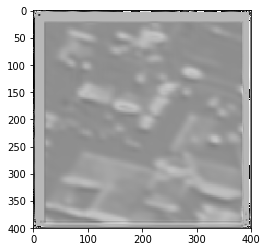

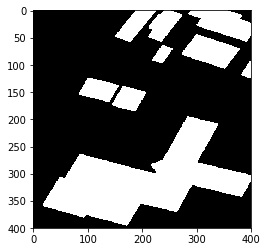

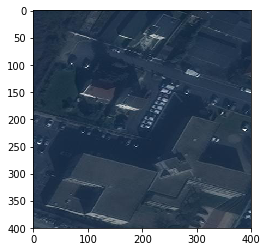

In [9]:
get_sample(trained_model.cuda())

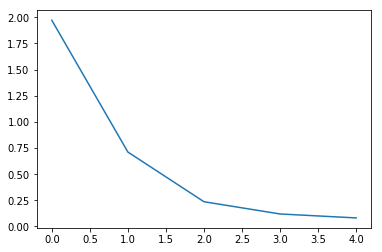

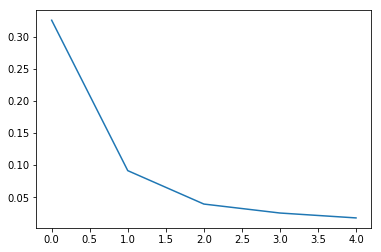

In [10]:
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-4, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/58 [00:00<?, ?it/s]

using GPU!


Validation epoch 4: 100%|██████████| 14/14 [00:01<00:00, 11.50it/s]


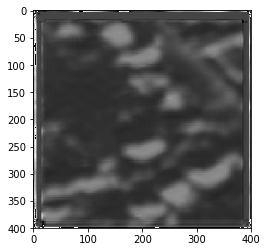

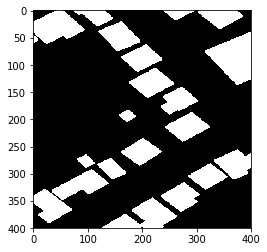

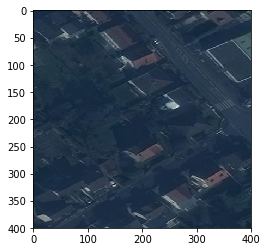

In [12]:
get_sample(trained_model.cuda())

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-5, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/58 [00:00<?, ?it/s]

using GPU!


Validation epoch 4: 100%|██████████| 14/14 [00:01<00:00, 11.01it/s]


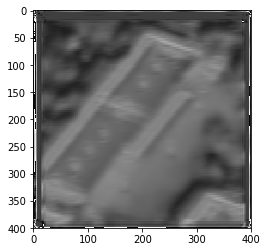

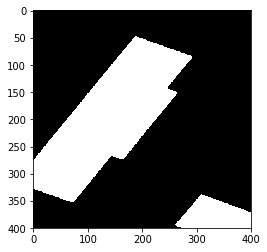

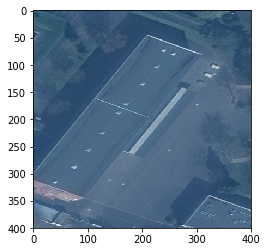

In [14]:
get_sample(trained_model.cuda())

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-6, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/58 [00:00<?, ?it/s]

using GPU!


Validation epoch 4: 100%|██████████| 14/14 [00:01<00:00, 11.77it/s]


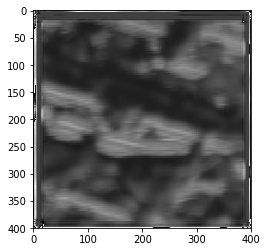

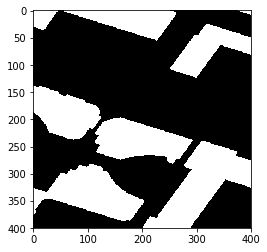

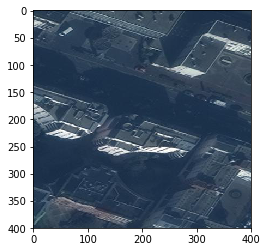

In [16]:
get_sample(trained_model.cuda())

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-7, weight_decay = 0.01 , betas = (0.9, 0.999))
trained_model = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/58 [00:00<?, ?it/s]

using GPU!


Validation epoch 4: 100%|██████████| 14/14 [00:01<00:00, 11.82it/s]


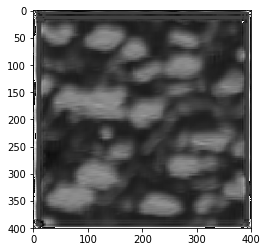

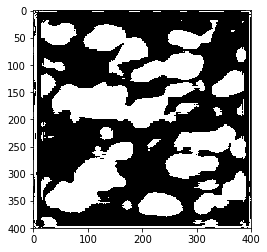

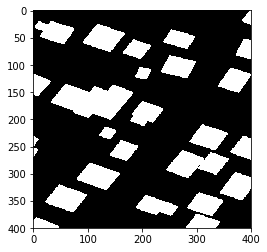

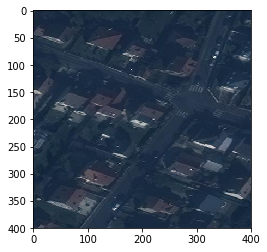

In [129]:
get_sample(trained_model.cuda())

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-7, weight_decay = 0.1 , betas = (0.9, 0.999))
trained_model2 = train_rnn_model(trained_model, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/58 [00:00<?, ?it/s]

using GPU!


Validation epoch 4: 100%|██████████| 14/14 [00:01<00:00, 11.72it/s]


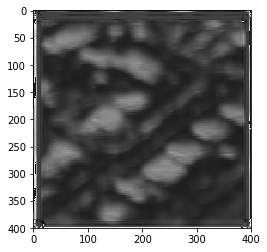

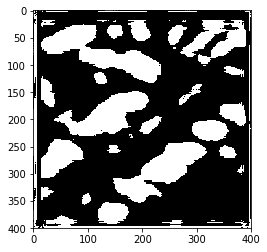

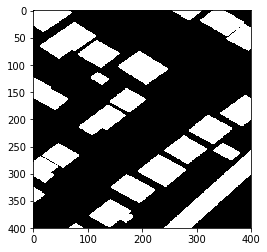

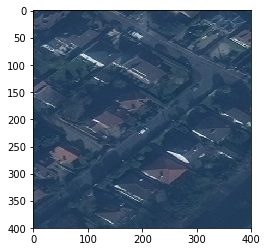

In [134]:
get_sample(trained_model2.cuda())

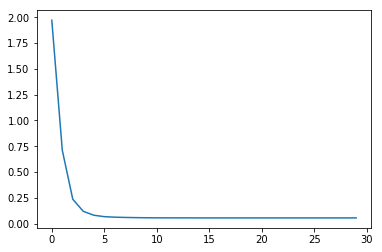

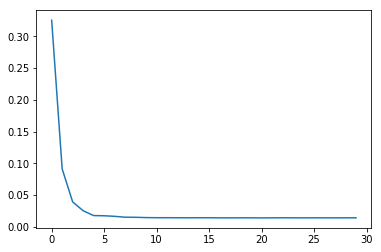

In [21]:
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-8, weight_decay = 0.1 , betas = (0.9, 0.999))
trained_model2 = train_rnn_model(trained_model2, criterion, optimizer, trainLoader, valLoader, n_epochs = 5, use_gpu = True)

Training epoch 0:   0%|          | 0/58 [00:00<?, ?it/s]

using GPU!


Validation epoch 4: 100%|██████████| 14/14 [00:01<00:00, 11.71it/s]


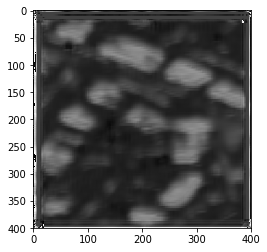

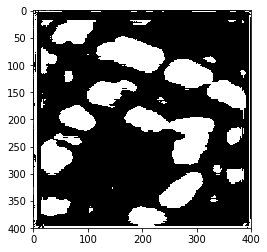

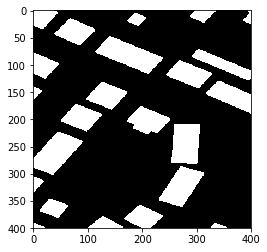

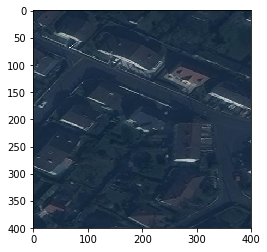

In [124]:
get_sample(trained_model2.cuda())

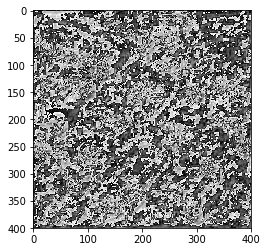

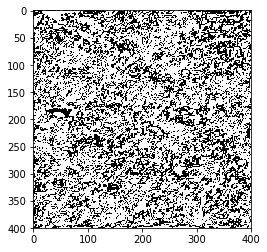

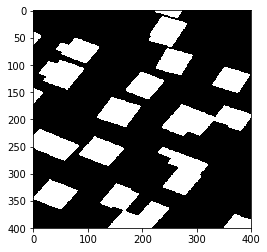

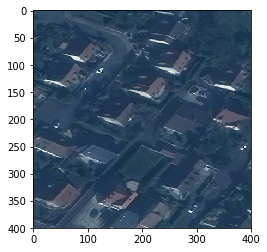

In [120]:
import random

imgTransform = transforms.Compose([transforms.ToTensor()])

def get_sample(model):
   # change it to Valdata if necessary, dont forget to change value inside rand()
    inp,out = valData[random.randint(0,97)]
    inp = inp.view(-1,3,400,400)
    sample_ip = torch.autograd.Variable(inp)
    sample_out = model(sample_ip)
    #print(sample_out.size())
    sample_out1 = sample_out.view(-1,sample_out.size(2),sample_out.size(3))
    #print(sample_out1.data)
    #sample_out1.data = sample_out1.data.clamp_(0,1)
    sample_out1 = cvt2pil(sample_out1.data.cpu()).convert('RGB')
    plt.imshow(sample_out1)
    plt.show()
    sample_out1 = np.where(np.asarray(sample_out1) >= 67,255,0)
    sample_out1 = cvt2pil(imgTransform(sample_out1))
    plt.imshow(sample_out1)
    plt.show()
    plt.imshow(cvt2pil(out.view(-1,400,400) * 255).convert('RGB') )
    plt.show()
    #sample_out = sample_out.view(-1,sample_out.size(2),sample_out.size(3))
    #sample_out1 = np.where(np.asarray(sample_out1.data.cpu().numpy()) >= 0, 0, 255)
    #sample_out = np.int32(sample_out)
    #imgTransform = transforms.Compose([transforms.ToTensor()])
    #sample_out = torch.from_numpy(sample_out)
    #sample_out = cvt2pil(sample_out.view(-1,400,400)) 
    sample_inp = cvt2pil(inp.view(-1,400,400)) 
    #print(sample_inp.shape)
    #print(out.shape)
    plt.imshow(sample_inp)
    plt.show()
    #plt.imshow(sample_out)
    #plt.show()
    #return (sample_out, sample_inp, out)
    
model = StanfordNet()
#modelS = StanfordNet()
get_sample(model)

In [125]:
torch.save(trained_model2,'./models/modelv3.pt')

/home/dipshil/anaconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type StanfordNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [135]:
torch.save(trained_model,'./models/badmodelv3.pt')